# 2021-12-02 • LIF vs Izhikevich subthreshold

Comparing neuron models: subthreshold behaviour of leaky integrate and fire vs Izhikevich neuron.

Not included: HH, AdEx.

## Prelude

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `lpxtf3` on `DUIP74576` on **Thu 02 Dec** 2021, at 17:32 (UTC+0000).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/c5b1d4f162089e77b577af2ef678c567aed73517
) (Mon 22 Nov 2021, 21:00).
Uncommited changes to 7 files.

## Input

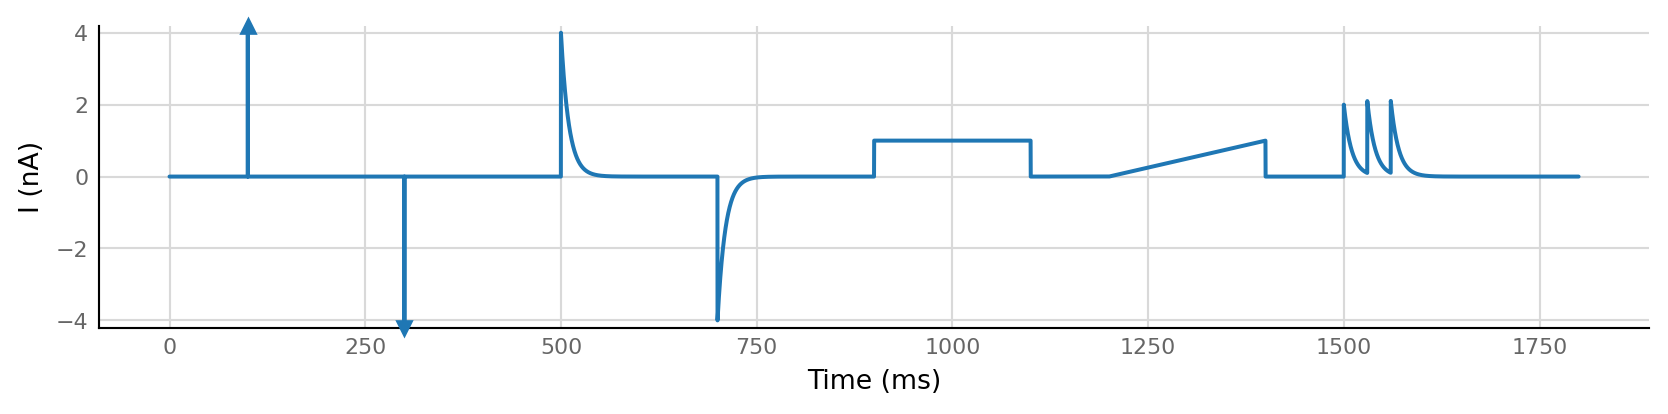

In [91]:
dt = 0.1 * ms
duration = 1800 * ms

ix = partial(v.to_indices, dt=dt)
timesteps = ix(duration)

I = np.zeros(timesteps)

def add_I(val, t, T):
    I[slice(*ix([t, t+T]))] += val

C = 2 * nA * 10 * ms

T_δ = dt
t_δ_up = 100 * ms
t_δ_down = 300 * ms
add_I(C / T_δ, t_δ_up, T_δ)
add_I(-C / T_δ, t_δ_down, T_δ)

# Pulse and exponential decay
T_pd = 200 * ms
t = np.linspace(0, T_pd, ix(T_pd), endpoint=False)
τ = 10 * ms
pulse_decay = 2 * C / τ * np.exp(-t / τ)
# Integral of f = exp(-t/τ) is -f/τ, so area from 0 to ∞ is τ.
add_I(pulse_decay, 500 * ms, T_pd)
add_I(-pulse_decay, 700 * ms, T_pd)

T_plat = 200 * ms
add_I(10 * C / T_plat, 900 * ms, T_plat)
# add_I(20 * C / T_plat, 1200 * ms, T_plat)

T_ramp = 200 * ms
t = np.linspace(0, T_ramp, ix(T_ramp), endpoint=False)
ramp = 5 * C / T_ramp * 2 * t / T_ramp
add_I(ramp, 1200 * ms, T_ramp)

add_I(pulse_decay * 0.5, 1500 * ms, T_pd)
add_I(pulse_decay * 0.5, 1530 * ms, T_pd)
add_I(pulse_decay * 0.5, 1560 * ms, T_pd)

# # For spikes
# I = np.zeros(timesteps)
# add_I(10 * C / T_plat, 900 * ms, T_plat)
# add_I(80 * C / T_plat, 1200 * ms, T_plat)

I = v.Signal(I, dt)

def plot_I(ax):
    v.plot_signal(I / nA, ax, time_units=ms)
    ax.set(xlabel="Time (ms)", ylabel='I (nA)')
    ylim = 2.1 * C / τ / nA
    ax.set_ylim(-ylim, ylim)
    ax.plot(t_δ_up / ms, ylim, "C0^", ms=5, clip_on=False)
    ax.plot(t_δ_down / ms, -ylim, "C0v", ms=5, clip_on=False, zorder=4);

fig, ax = plt.subplots(**v.figsize(aspect=5, width=1000))
plot_I(ax)

In [92]:
def normalise(V, V_rest):
    shifted = V - V_rest
    normalised = shifted / np.max(shifted)
    return v.Signal(normalised, dt)

## Leaky integrate and fire

In [93]:
def sim_LIF(I):
    V_L = -65 * mV
    V_th = -50 * mV
    V_peak = 35 * mV  # just for plotting
    V_reset = V_L
    V0 = V_reset
    R = 10 * Mohm
    τ = 15 * ms  # = CR

    N = I.size
    V = np.ones(N) * V0

    for i in range(N-1):

        V[i+1] = V[i] + dt * ((V_L - V[i]) + R*I[i]) / τ

        if V[i+1] > V_th:
            V[i] = V_peak
            V[i+1] = V_reset

    return normalise(V, V_L)

V_LIF = sim_LIF(I);

Parameters from Dayan & Abott, fig 5.5 (but with τ = 15 ms instead of 10).

## Izhikevich

In [115]:
def sim_Izh(I):
    
    C = 260 * pF
    k = 0.7 * (nS/mV)
    b = -2 * nS
    V_r = -65 * mV
    V_t = -40 * mV
    V_peak = 35 * mV
    c = -50 * mV
    a = 0.03 / ms
    d = 100 * pA
    
    N = I.size
    V = np.ones(N) * V_r
    u = np.zeros(N)
    
    for i in range(N-1):
        
        V[i+1] = V[i] + dt * (k * (V[i] - V_r)*(V[i] - V_t) - u[i] + I[i]) / C
        u[i+1] = u[i] = dt * a * (b * V[i] - u[i])
        
        if V[i+1] > V_peak:
            V[i] = V_peak
            V[i+1] = c
            u[i+1] += d
    
    return normalise(V, V_r)

V_Izh = sim_Izh(I * 0.02);  # subthr
# V_Izh = sim_Izh(I * 0.2);  # spikes

Parameters from Izhikevich book: cortical regular spiking neuron.  
Resting potential was set to -65 mV instead of -60, to match the LIF neuron above.  
Capacitance C and input current scaling factor were manually adjusted until the LIF and Izh voltage responses overlapped well.

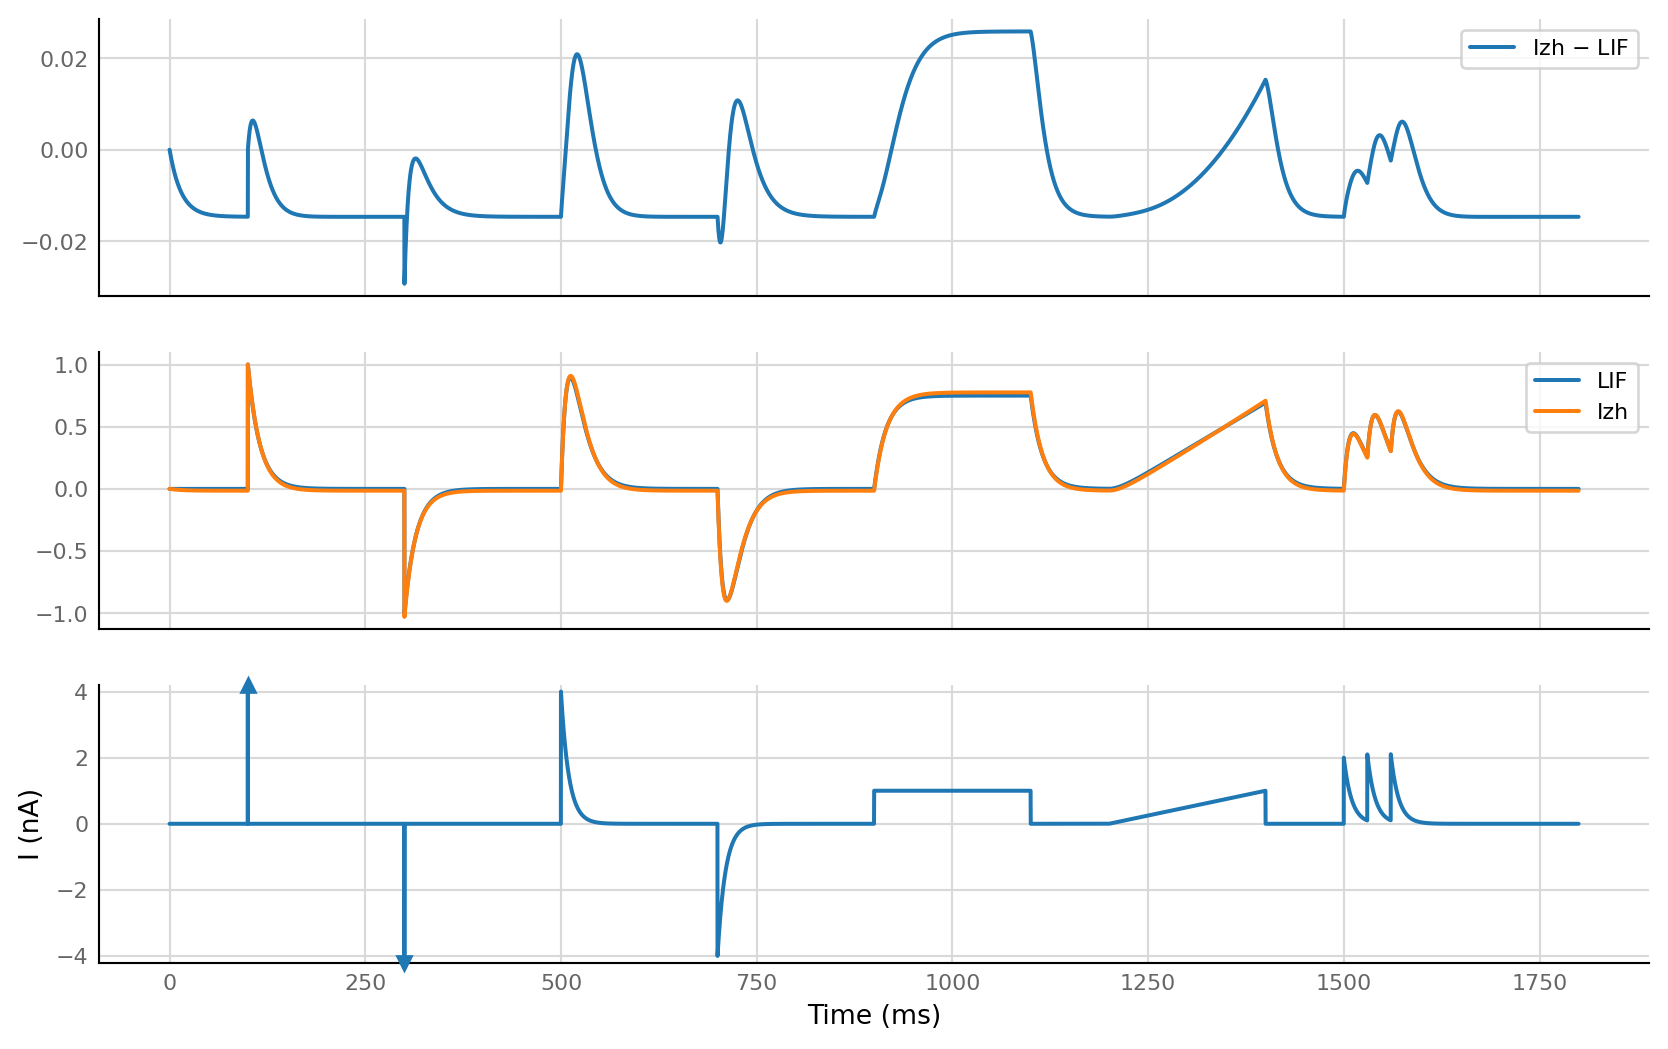

In [116]:
fig, axes = plt.subplots(nrows=3, **v.figsize(aspect=1.6, width=1000))
axes = list(reversed(axes))  # start indexing from bottom

plot_I(axes[0])
v.plot_signal(V_LIF, axes[1], lw=1.5, label="LIF");
v.plot_signal(V_Izh, axes[1], lw=1.5, label="Izh");
# v.plot_signal(V_Izh, axes[2], lw=2);
v.plot_signal(V_Izh - V_LIF, axes[2], label="Izh $-$ LIF")
for i in range(1, len(axes)):
    axes[i].set_xticklabels([])
    axes[i].legend()

Related, see fitting of AdEx to HH here: http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model#Relation_to_other_models.  
They both have downwards curving (concave) voltage between spikes under step current; only _just_ before spike does the voltage curve upwards.

## Reproducibility

In [4]:
v.print_reproducibility_info(verbose=True) 

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Thu 02 Dec** 2021, at 12:51 (UTC+0000).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/c5b1d4f162089e77b577af2ef678c567aed73517
) (Mon 22 Nov 2021, 21:00).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/support/misc.py
?? notebooks/2012-12-02__comparing_neuron_models.ipynb
?? notebooks/2021-11-18__constant_input_spikes.ipynb
?? notebooks/2021-11-18__prototype_new_sim.ipynb
?? website/thesis/references.bib
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     21.9b0             pyhd8ed1ab_1    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brian2                    2.5.0.1          py39h2e07f2f_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2                    pypi_0    pypi
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
colorful                  0.5.4                    pypi_0    pypi
conda                     4.11.0           py39hcbf5309_0    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
cython                    0.29.24          py39h415ef7b_1    conda-forge
dataclasses               0.8                pyhc8e2a94_3    conda-forge
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
gsl                       2.7                  hdfb1a43_0    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
intel-openmp              2021.4.0          h57928b3_3556    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
kiwisolver                1.3.1                    pypi_0    pypi
libblas                   3.9.0              12_win64_mkl    conda-forge
libcblas                  3.9.0              12_win64_mkl    conda-forge
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
liblapack                 3.9.0              12_win64_mkl    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libxml2                   2.9.12               hf5bbc77_0    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
lxml                      4.6.3            py39h4fd7cdf_0    conda-forge
m2w64-gcc-libgfortran     5.3.0                         6    conda-forge
m2w64-gcc-libs            5.3.0                         7    conda-forge
m2w64-gcc-libs-core       5.3.0                         7    conda-forge
m2w64-gmp                 6.1.0                         2    conda-forge
m2w64-libwinpthread-git   5.0.0.4634.697f757               2    conda-forge
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
mkl                       2021.4.0           h0e2418a_729    conda-forge
mpmath                    1.2.1              pyhd8ed1ab_0    conda-forge
msys2-conda-epoch         20160418                      1    conda-forge
mypy_extensions           0.4.3            py39hcbf5309_4    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pathspec                  0.9.0              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
platformdirs              2.3.0              pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prettyprinter             0.18.0                   pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
py-cpuinfo                8.0.0              pyhd8ed1ab_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pympler                   0.9                      pypi_0    pypi
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py39hcbf5309_7    conda-forge
pyqt-impl                 5.12.3           py39h415ef7b_7    conda-forge
pyqt5-sip                 4.19.18          py39h415ef7b_7    conda-forge
pyqtchart                 5.12             py39h415ef7b_7    conda-forge
pyqtwebengine             5.12.1           py39h415ef7b_7    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
regex                     2021.10.23       py39hb82d6ee_1    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
sympy                     1.9              py39hcbf5309_1    conda-forge
tbb                       2021.4.0             h2d74725_1    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tomli                     1.2.2              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typed-ast                 1.4.3            py39hb82d6ee_1    conda-forge
typing_extensions         3.10.0.2           pyha770c72_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
```